<a href="https://colab.research.google.com/github/marcus-wuertz/Analytics-Code/blob/main/Quantile_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## $\color{red}{\text{Lecture Overview}}$
1. **Quantile Regression**
2. **Developing the Analytic Task**
3. **Data Transformation**
4. **Data Visualization**
5. **Data Modeling**
6. **Compare Multpile Linear Regression with Quantile Regression**

## $\color{red}{\text{Quantile Regression}}$

1. Muliple linear regression models the expected value of the dependent variable given a set of independent variables
    - $E(y|X)=b_0 + b_1X_1 + ... + b_kX_k $
    - $y$ is the **dependent variable** and $X_1, X_2, ..., X_k$ are the **independent variables**
2. Multiple linear regression also assumes that the model has a constant error
3. Quantile regression models the quantile of the dependent variable given a set of independent variables
    - $E(q(y)|X)=b_0 + b_1X_1 + ... + b_kX_k $
    - $q(y)$ is the **quantile of the dependent variable** and $X_1, X_2, ..., X_k$ are the **independent variables**

## $\color{red}{\text{Import Required Packages}}$

In [1]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pylab as plt

## $\color{red}{\text{Import Data}}$

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive/Python Data
housing_df=pd.read_csv('housingData.csv')

/content/drive/MyDrive/Python Data


## $\color{red}{\text{Analytic Task}}$
1. Using the housing data, build a **Quantile regression model** to predict **price**
2. Perform data transformation methods wherever needed
3. Perform data visualization tasks to develop a preliminary understanding of **price**
4. Develop a model to predict **price**
5. Assess the robustness of the model
6. Interpret the model for insights

## $\color{red}{\text{Data Transformation}}$


### $\color{blue}{\text{Missing Value Analysis}}$

- Check missing values in the data

In [4]:
# Function to compute missing values
def percent_missing(data):
    return data.isnull().sum().divide(len(data)).sort_values(ascending=False)

# Using the function
percent_missing(housing_df).head()

id               0.0
sqft_above       0.0
sqft_lot15       0.0
sqft_living15    0.0
long             0.0
dtype: float64

### $\color{blue}{\text{Multicollinearity}}$

1. Using a correlation plot, find variables with strong association with the dependent variable, **price**
2. **Multicollinearity** occurs when variables have similar information
    - Variables with a correlation greater than 0.70 are considered to have similar information
    - One of the variables should not be included in the analysis
3. Which variables are closely related to each other?

In [8]:
 #!pip install dython
from dython.nominal import associations
import seaborn as sns

def corrPlot(data):

  # Use "associations" function to compute correlation between all variables
  corr_matrix = associations(dataset=data, compute_only=True)['corr']

  # Mask the upper triangle of correlation heatmap
  mask_upper = np.triu(np.ones_like(corr_matrix, dtype=bool))

  # Plotting correlation heatmap
  plt.figure(figsize=(12, 8))
  sns.heatmap(corr_matrix, annot=True, mask=mask_upper, cmap='coolwarm_r', fmt='.2f', vmin=-1, vmax=1)
  plt.show()

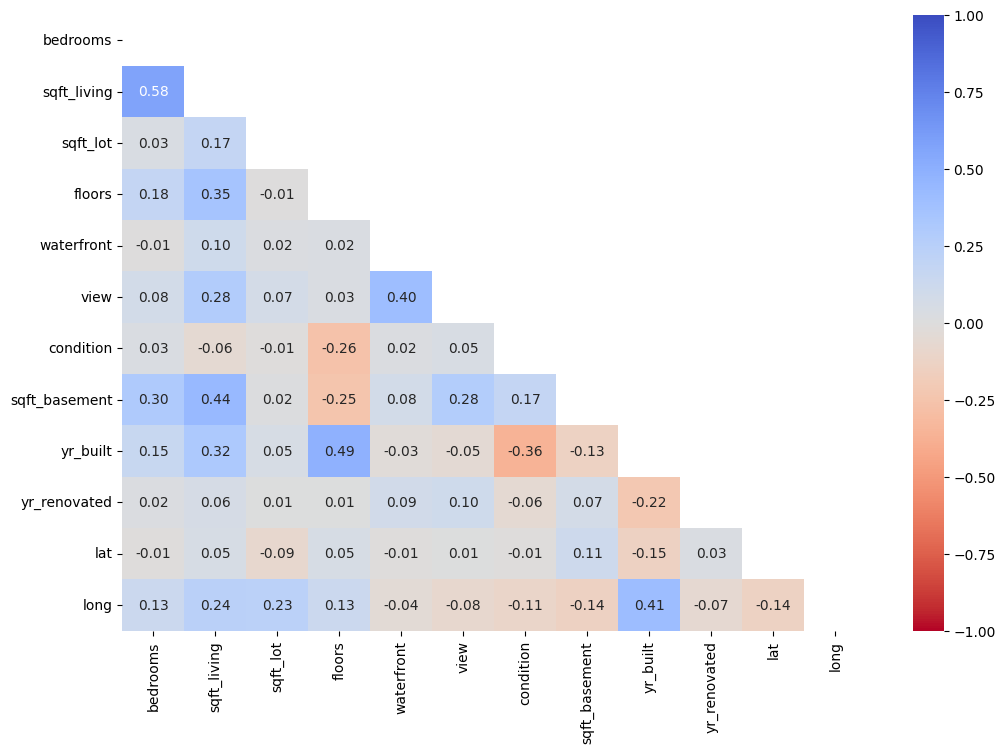

In [12]:
## Run following cell before this one to define function
# drop the following variables from the data as they are not needed for the analysis
drop_vars=['id','date','zipcode','price']
new_housing=housing_df.drop(drop_vars, axis=1)

# use function to remove variables with high correlations
dropped_vars, new_housing_v2=drop_highly_correlated(data=new_housing, threshold=0.7)

#use function to get corrplot to see correlation
corrPlot(data=new_housing_v2)

### $\color{blue}{\text{Removing Colinear Variables}}$
- If correlation between variables are greater than 0.7, one of the variables should be removed

In [10]:
'''
This function drops highly correlated variables given a threshold.
It drops the variable with smaller variance
'''

def drop_highly_correlated(data, threshold):
    cor_matrix = data.corr().abs()
    sol = (cor_matrix.where(np.triu(np.ones(cor_matrix.shape), k=1).astype(bool))).unstack().dropna()

    to_drop=[]
    for i in range(len(sol[sol > threshold].index.tolist())):
        var1 = sol[sol >= threshold].index.tolist()[i][0]
        var2 = sol[sol >= threshold].index.tolist()[i][1]

        if(data[var1].var() < data[var2].var()): to_drop.append(var1)
        else: to_drop.append(var2)

    dropped_vars = list(set(to_drop))
    return dropped_vars, data.drop(dropped_vars, axis=1)

### $\color{blue}{\text{Removing Near Zero-Variance Variables}}$
- Some variables have little or no variation. They do not add much value to the model

In [13]:
from sklearn.feature_selection import VarianceThreshold as varThresh

vThreshold=varThresh(threshold=0.1)
vThreshold.fit_transform(new_housing_v2)

# get variables with greater variance
vars= new_housing_v2.columns[vThreshold.get_support()]

# subset the data for variables with greater variance
housing_varDf=new_housing_v2[vars]

### $\color{blue}{\text{Standardization}}$

- To reduce the effect of outliers

In [14]:
from sklearn.preprocessing import StandardScaler as ss

# standardize data
housing_std=ss().fit_transform(housing_varDf)
housing_stdDf=pd.DataFrame(housing_std, columns=housing_varDf.columns)

# dont standardize dependent, its the one we're analyzing. thats why we take it out
#bring dependent back into standardized data
housing_std_full=pd.concat([housing_stdDf, housing_df['price']], axis=1)

### $\color{blue}{\text{Data Partitioning}}$

1. Identify dependent and independent variables
2. Partition the data such that 80% is used for training and 20% is used for testing

In [15]:
from sklearn.model_selection import train_test_split as tts

# independent variables to be used in the model
indVar=housing_std_full
depVar=housing_std_full['price']

# partitionm data into training and testing
trainX,testX,trainY,testY=tts(indVar,depVar,test_size=0.2,random_state=45)

### $\color{blue}{\text{Model Fitting and Result}}$

#### $\color{green}{\text{Quantile Regression}}$

In [16]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

# join all variables like a linear equation
equation=' + '.join(trainX.drop('price', axis=1).columns)

#regression equation
reg_formula='price ~ '+equation

#build the quantile regression model
quant_reg=smf.quantreg(reg_formula, trainX).fit(0.8)
print(quant_reg.summary())

                         QuantReg Regression Results                          
Dep. Variable:                  price   Pseudo R-squared:               0.4155
Model:                       QuantReg   Bandwidth:                   2.721e+04
Method:                 Least Squares   Sparsity:                    6.350e+05
Date:                Mon, 04 Mar 2024   No. Observations:                17290
Time:                        19:50:32   Df Residuals:                    17280
                                        Df Model:                            9
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      6.783e+05   1932.247    351.034      0.000    6.74e+05    6.82e+05
bedrooms      -4.952e+04   2742.893    -18.056      0.000   -5.49e+04   -4.41e+04
sqft_living    2.875e+05   3671.628     78.299      0.000     2.8e+05    2.95e+05
sqft_lot      -6195.3621   2422.270  

#### $\color{green}{\text{Multiple Linear Regression}}$

In [17]:
# add an intercept term
trainX=sm.add_constant(trainX)

#model with the training data
mlr_model=sm.OLS(trainX['price'],trainX.drop('price',axis=1)).fit()

#print model summary
print(mlr_model.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.585
Model:                            OLS   Adj. R-squared:                  0.585
Method:                 Least Squares   F-statistic:                     2712.
Date:                Mon, 04 Mar 2024   Prob (F-statistic):               0.00
Time:                        19:50:37   Log-Likelihood:            -2.3846e+05
No. Observations:               17290   AIC:                         4.769e+05
Df Residuals:                   17280   BIC:                         4.770e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          5.402e+05   1797.331    300.579

### $\color{blue}{\text{Model Prediction}}$

- Predict the **price** of the testing data as a function of the independent variables

#### $\color{green}{\text{Quantile Regression}}$

In [18]:
# get predicted house prices for the quantile regression
qr_pred_test=quant_reg.predict(testX)

#### $\color{green}{\text{Multiple Linear Regression}}$

In [19]:
# add constant to the testing data
testX=sm.add_constant(testX)

# predict for mlr
mlr_pred=mlr_model.predict(testX.drop('price', axis=1))


## $\color{red}{\text{Model Diagnostics}}$

### $\color{blue}{\text{Error Calculations}}$

- Mean Error (ME), Root Mean Squared Error (RMSE)
- Mean Absolute Error (MAE), Mean Percentage Error (MPE)
- Mean Absolute Percentage Error (MAPE)

#### $\color{green}{\text{Quantile Regression}}$

In [22]:
#!pip install dmba
from dmba import regressionSummary

# compute the regression diagnostics
print('***************************** Testing Data********************************')
regressionSummary(testX['price'],qr_pred_test)

***************************** Testing Data********************************

Regression statistics

                      Mean Error (ME) : -137965.9932
       Root Mean Squared Error (RMSE) : 283608.0653
            Mean Absolute Error (MAE) : 209152.9574
          Mean Percentage Error (MPE) : -43.1646
Mean Absolute Percentage Error (MAPE) : 50.1250


#### $\color{green}{\text{Multiple Linear Regression}}$

In [23]:


# compute the multiple linear regression diagnostics
print('***************************** Testing Data********************************')
regressionSummary(testX['price'],mlr_pred)

***************************** Testing Data********************************

Regression statistics

                      Mean Error (ME) : -289.4742
       Root Mean Squared Error (RMSE) : 244192.0543
            Mean Absolute Error (MAE) : 158682.3531
          Mean Percentage Error (MPE) : -10.9189
Mean Absolute Percentage Error (MAPE) : 32.6947
